In [ ]:
"""
Identifying storms from "story-clusters" of articles based on the following criterion: 

1. Story cluster is over a particular duration threshold 
2. Contains X or more outlets reporting in "storm mode"

Reporting in "storm mode" means... 
1. The outlet has over X percent of its coverage during a X day window dedicated to the story cluster 
2. During that X day window, the outlet published over X articles 
"""

In [2]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
STORM_CLUSTS_OUT_PATH = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"

In [2]:
#set cutoffs 

#minimum number of articles written during 3 day window 
ARTICLE_COUNT = 40 

#reporting percent required to be in "storm mode"
REPORTING_PERCENT = 3

#the number of outlets in "storm mode" to consider the story a storm 
OUTLET_CUTOFF = 5

In [4]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])


#only keep data 
#first day of local coverage in our data, 4/1
firstLocDate = min(df.loc[df["national"] == False, "date"])

df = df[df["date"] > firstLocDate]
len(df)


<ipython-input-4-b658fbf83435>:2: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


4222409

In [5]:
CLUST_PIPE = "20000_90"

print(f"{df.dropna(subset=[CLUST_PIPE]).shape} articles didn't make it into an entity grouping") 

(1375105, 50) articles didn't make it into an entity grouping


In [6]:
#group clustered articles into rows 
longClusts = df[[CLUST_PIPE,"date"]].groupby(CLUST_PIPE).agg(list)

In [7]:
def numDays(inList): 
    return (max(inList) - min(inList)) / timedelta(hours=24)

#get cluster duration and size 
longClusts["clustLength"] = longClusts["date"].apply(numDays)
longClusts["numStories"] = longClusts["date"].apply(len)

In [8]:
#remove shorter stories 
longClusts = longClusts[(longClusts["clustLength"] > 5)].reset_index()

#take the long clusters and keep those rows in the long form article-per-row dataframe
longClusts = df[df[CLUST_PIPE].isin(longClusts[CLUST_PIPE].unique())]

In [9]:
print(f"{len(longClusts)} articles in clusters over 5 days") 
print(f"{len(longClusts[CLUST_PIPE].unique())} clusters over 5 days")

117935 articles in clusters over 5 days
10475 clusters over 5 days


In [10]:
#now we start time-series part 
dateDf = longClusts[["source", "date", CLUST_PIPE]].sort_values("date")

#used for counting later 
dateDf["count"] = 1

In [13]:
#used for counting later 
df["count"] = 1

#within each outlet, get the 3 day rolling window of coverage 
#count the number of articles in that 3 day window 
timeRolling = df[["source", "date", "count"]].groupby(by=["source", "date"]).agg(sum).reset_index()
timeRolling = timeRolling.groupby("source").rolling("3D", on="date").sum() #.rolling("3D", on="date").sum()
timeRolling = timeRolling.reset_index().drop(columns=["level_1"])

In [206]:
#quick sanity check - shows that we don't have duplicate days 
print(len(timeRolling))
print(len(df.drop_duplicates(subset=["source", "date"])))

285585
285585


In [16]:
#within each outlet and cluster, get the three day rolling window of coverage 
timeRollingClust = dateDf.groupby(["source", CLUST_PIPE, "date"]).sum()\
.reset_index().groupby(["source", CLUST_PIPE]).rolling("3D", on="date").sum()

timeRollingClust = timeRollingClust.reset_index().drop(columns=["level_2"])

In [17]:
#same sanity check as above 
print(len(timeRollingClust))
print(len(timeRollingClust.drop_duplicates(subset=["source", CLUST_PIPE, "date"])))

109086
109086


Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet level')

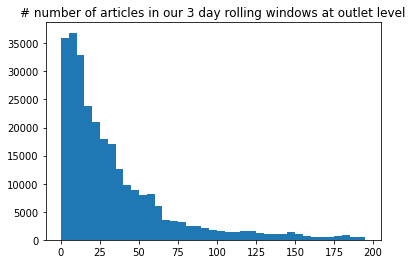

In [18]:
plt.hist(timeRolling["count"], bins=np.arange(0, 200, 5))
plt.title("# number of articles in our 3 day rolling windows at outlet level")

Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet,cluster level')

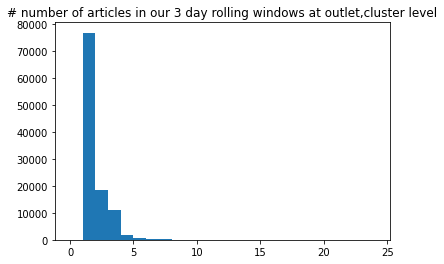

In [154]:
plt.hist(timeRollingClust["count"], bins=np.arange(0, 25, 1))
plt.title("# number of articles in our 3 day rolling windows at outlet,cluster level")
#interpretation: for most stories, outlets report a very small amount on that story in a 3 day window 

In [19]:
timeRollingClust.head()

source  20000_90       date  count
0  21stcenturywire     836.0 2021-02-23    1.0
1  21stcenturywire     959.0 2021-03-30    1.0
2  21stcenturywire    2457.0 2021-11-13    1.0
3  21stcenturywire    3075.0 2020-07-11    1.0
4  21stcenturywire    3216.0 2020-08-12    1.0

In [99]:
#now we have the 3 day windows where we get total coverage and coverage for each cluster 
stormDf = pd.merge(timeRolling, timeRollingClust.rename(columns={"count":"clustCount"}), on=["source", "date"])

stormDf["reportingPercent"] = (stormDf["clustCount"] / stormDf["count"]) * 100

In [100]:
#sort storm df so we get the largest three day window for an outlet,cluster appearing first\
#then drop duplicates. Has the effect of keeping only the largest 3-day window for each outlet in each cluster 
stormDf = stormDf.sort_values(["source", CLUST_PIPE, "reportingPercent"], ascending=False)
stormDf = stormDf.drop_duplicates(["source", CLUST_PIPE], keep="first")

<Axes: xlabel='count', ylabel='Proportion'>

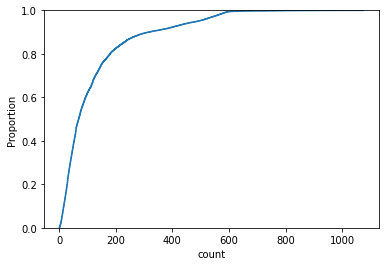

In [101]:
#example interpretation: 80% of 3-day periods have 200 or less articles in them 
sns.ecdfplot(x="count", data=stormDf)

In [102]:
#keep only the 3 day windows where over 40 articles were reported 
#TODO: apply the cutoff before taking the max 3-day window 
stormDf = stormDf[stormDf["count"] >= ARTICLE_COUNT]

<Axes: xlabel='reportingPercent', ylabel='Density'>

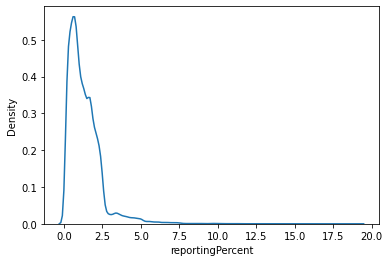

In [103]:
sns.kdeplot(x="reportingPercent", data=stormDf)

In [1]:
#is there an inflection point here 
sns.ecdfplot(x="reportingPercent", data=stormDf)
plt.title("Empirical CDF: Coverage Dedicated to Event-Clusters")
plt.xlabel("% Dedicated to Event Cluster")
plt.ylabel("Proportion of 3-Day Windows")

NameError: name 'sns' is not defined

In [162]:
#the telegraph reporting on black friday and cyber monday 
#test = df.loc[(df[CLUST_PIPE] == 5130.0) & (df["source"] == "drudgereport"), ["title", "content", "source", "date"]]

#sns.lineplot(x="date",y="source", data=test[["date", "source"]].groupby("date").agg(len).reset_index())

#epoch times hurricane Ida 
#test = df.loc[(df[CLUST_PIPE] == 8716.0) & (df["source"] == "theepochtimes"), ["title", "content", "source", "date"]]

In [105]:
# decide if three day window of coverage is in storm mode 
stormDf["isStorm"] = stormDf["reportingPercent"] >= REPORTING_PERCENT

#group at the story cluster level, so we now have each story cluster
#and whether the outlets in that cluster reported in storm mode 
storyStormDf = stormDf[[CLUST_PIPE,"isStorm", "source"]].groupby(CLUST_PIPE).agg({"isStorm":[np.mean, sum,list], "source":list}) #.rename(columns={"reportingPercent":"outletStormPercent"})
storyStormDf.columns = storyStormDf.columns.droplevel()
storyStormDf = storyStormDf.reset_index()

storyStormDf.columns = ["20000_90", "average_reporting_percent", "num_outlets_over_cutoff", "isStorm", "source"]

In [167]:
def getStormOutlets(inRow): 
    outlist = []
    for i, isStorm in enumerate(inRow["isStorm"]): 
        if isStorm: 
            outlist.append(inRow["source"][i])
    return outlist 

storyStormDf["stormSource"] = storyStormDf.apply(getStormOutlets, axis=1)

In [168]:
storyStormDf = storyStormDf.drop(columns=["isStorm", "source"])

#when we have at least OUTLET_CUTOFF outlets on board, we have a storm 
stormClusts = list(storyStormDf.loc[storyStormDf["num_outlets_over_cutoff"] >= OUTLET_CUTOFF, CLUST_PIPE])

In [170]:
#how many storms are there? 
len(stormClusts)

98

In [3]:
"""
for looking at the headlines of storm articles 
stormArticles = df[df[CLUST_PIPE] ==  2965.0]
#[item[:300] for item in list(stormArticles.sort_values("date").sample(30)["content"])]

for i, row in stormArticles.sample(10).sort_values("date").iterrows(): 
    print(row["title"])
    print(row["date"])
    
"""

'\nfor looking at the headlines of storm articles \nstormArticles = df[df[CLUST_PIPE] ==  2965.0]\n#[item[:300] for item in list(stormArticles.sort_values("date").sample(30)["content"])]\n\nfor i, row in stormArticles.sample(10).sort_values("date").iterrows(): \n    print(row["title"])\n    print(row["date"])\n    \n'

In [174]:
storyStormDf[CLUST_PIPE + "_storm"] = True
storyStormDf = storyStormDf.rename(columns={"stormSource":CLUST_PIPE + "_storm_source", "average_reporting_percent":CLUST_PIPE + "_average_pct", "num_outlets_over_cutoff":CLUST_PIPE + "_num_over_cutoff"})
outDf = pd.merge(df[["key", CLUST_PIPE]], storyStormDf[storyStormDf[CLUST_PIPE + "_num_over_cutoff"] >= 5], on=CLUST_PIPE, how="right")

In [179]:
#print storm cluster sizes 
outDf[CLUST_PIPE].value_counts()

20000_90
8088.0      1378
533.0       1026
608.0        737
6876.0       622
4708.0       525
            ... 
19801.0       57
234960.0      57
111378.0      54
130664.0      52
94487.0       51
Name: count, Length: 98, dtype: int64

In [182]:
#output storm labels 
#outDf contains all articles that are a part of storms 
outDf.to_csv(STORM_CLUSTS_OUT_PATH, sep="\t")